In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler, MinMaxScaler 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,plot_confusion_matrix
import warnings
warnings.filterwarnings("ignore")





In [59]:
data= pd.read_csv('https://dqlab-dataset.s3-ap-southeast-1.amazonaws.com/dqlab_telco.csv')
#data.head()

In [60]:
print('Number of row = {}'.format(data.shape[0]))
print('Number of column = {}'.format(data.shape[1]))

Number of row = 7113
Number of column = 22


In [61]:
data=data.sort_values('UpdatedAt',ascending=False).drop_duplicates('customerID')
data['valid']=data['customerID'].astype(str).str.match(r'(45\d{9,10})')
data = (data[data['valid'] == True]).drop('valid', axis = 1)
#print(data.head())

In [62]:
data.isna().sum()

UpdatedAt            0
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure              99
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges      26
TotalCharges        15
Churn               43
dtype: int64

In [63]:
data=data.dropna(subset=['Churn','MonthlyCharges','TotalCharges','tenure'], how='any')
data_filtered=data.drop(columns=['UpdatedAt','customerID'], axis=1)
print('Number of row = {}'.format(data_filtered.shape[0]))
print('Number of column = {}'.format(data_filtered.shape[1]))

Number of row = 6810
Number of column = 20


In [64]:
data_filtered.dtypes


gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure              float64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [65]:
data_filtered.SeniorCitizen=data['SeniorCitizen'].astype(str)

In [66]:
data_filtered.columns.to_list()

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

In [67]:
for col in data_filtered.columns:
    print(col,':',data_filtered[col].unique())

gender : ['Female' 'Male' 'Laki-Laki' 'Wanita']
SeniorCitizen : ['0' '1']
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes' 'Iya']
tenure : [  1.  12.  64.  56.  72.  15.  24.   5.  44.  39.  71.   2.  19.  31.
  69.  46.  60.  50.  34.  35.  36.   3.   6.  37.  58.  66.  22.  33.
  68.   4.  23.   9.  20.  25.  10.  70.  27.  18.  43.  26.  13.  51.
  67.  38.  65.  32.  49.  16.  54.  21.  59.  52.  53.  41.   7.  57.
   8.  28.  30.  48.  63.  55.  62.  61.  17.  29.  45.  42.  40.  14.
  47. 500.]
PhoneService : ['No' 'Yes']
MultipleLines : ['No phone service' 'No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes' 'No internet service']
OnlineBackup : ['Yes' 'No internet service' 'No']
DeviceProtection : ['No' 'Yes' 'No internet service']
TechSupport : ['No' 'No internet service' 'Yes']
StreamingTV : ['No' 'No internet service' 'Yes']
StreamingMovies : ['No' 'No internet service' 'Yes']
Contract : ['Month-to-month' 'Two year' 'One year']
PaperlessBillin

In [68]:
data_filtered= data_filtered.replace(['Wanita','Laki-Laki','Churn','Iya','No phone service','No internet service','0','1'],
                                     ['Female','Male','Yes','Yes','No','No','No','Yes'])

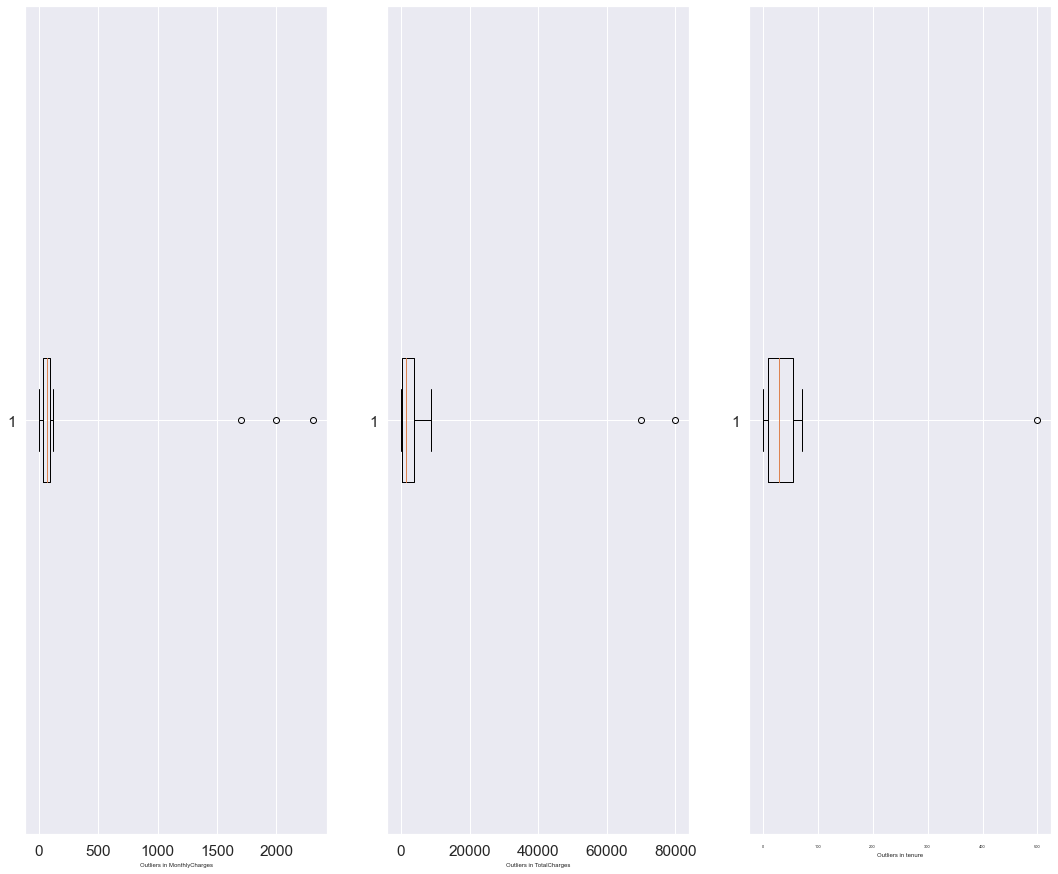

In [69]:
num_features=['MonthlyCharges','TotalCharges','tenure']
for i, feature in enumerate(num_features,1):    
    plt.subplot(1, 3,i)
    plt.boxplot(data_filtered[feature], vert=0)
    plt.xlabel('Outliers in {}'.format(feature), size=6, labelpad=4) 

    
plt.subplots_adjust(right=2.5, top=3)
  
plt.tick_params(axis='x', labelsize=4)
   

plt.show()

In [70]:
# Handling with IQR
Q1 = (data_filtered[['tenure','MonthlyCharges','TotalCharges']]).quantile(0.25)
Q3 = (data_filtered[['tenure','MonthlyCharges','TotalCharges']]).quantile(0.75)

IQR = Q3 - Q1
maximum = Q3 + (1.5*IQR)
minimum = Q1 - (1.5*IQR)

more_than = (data_filtered> maximum)
lower_than = (data_filtered < minimum)
data_filtered = data_filtered.mask(more_than, maximum, axis=1)
data_filtered = data_filtered.mask(lower_than, minimum, axis=1)

In [71]:
target=data_filtered['Churn'].copy()
data_filtered=data_filtered.drop(columns='Churn',axis=1)

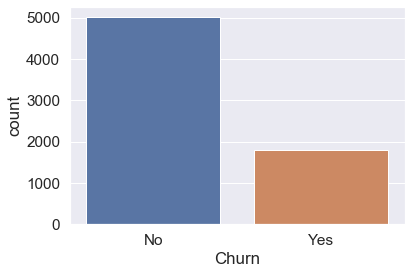

In [72]:
sns.countplot(x=target)

In [73]:
#Define column group with same processing
ord_features=['gender','Partner','SeniorCitizen','Dependents','PhoneService','PaperlessBilling','MultipleLines',
              'OnlineSecurity','OnlineBackup', 'DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
num_features=['MonthlyCharges','TotalCharges','tenure']
nom_features=['Contract','PaymentMethod','InternetService']

#
ord_transform=LabelEncoder()
num_transform=StandardScaler()
nom_transform=OneHotEncoder()

for col in ord_features:
    data_filtered[col] = ord_transform.fit_transform(data_filtered[col])

preprocessor=ColumnTransformer(transformers=[
        ('num', num_transform, num_features),
        ('nom',nom_transform, nom_features)],
        remainder='passthrough')

In [74]:
X=data_filtered
y=target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1)

In [75]:
# Fit the pipeline on the training set and then transform the training and test set
preprocessor.fit(X_train)
X_train=preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)


In [76]:
LE=LabelEncoder()
LE.fit(y_train)
y_train=LE.transform(y_train)
y_test=LE.transform(y_test)

In [77]:
table_score = pd.DataFrame(columns=["Machine_Learning", "test_score"])

row_index = 0

In [78]:
Machine_Learning=[
                  ExtraTreesClassifier(),
                  DecisionTreeClassifier(),
                  RandomForestClassifier(),
                  KNeighborsClassifier()]


for i in Machine_Learning:
    i.fit(X_train, y_train)
    y_pred = i.predict(X_test)
    table_score.loc[row_index, 'test_score'] = accuracy_score(y_test, y_pred)
    table_score.loc[row_index, 'Machine_Learning'] = i
    row_index+=1



In [79]:
# Display the results table, sorted in descending order
table_score = table_score.sort_values(by='test_score', ascending=False)
table_score

,Machine_Learning,test_score
2,"(DecisionTreeClassifier(max_features='auto', r...",0.784875
0,"(ExtraTreeClassifier(random_state=167624276), ...",0.777533
3,KNeighborsClassifier(),0.772394
1,DecisionTreeClassifier(),0.725404


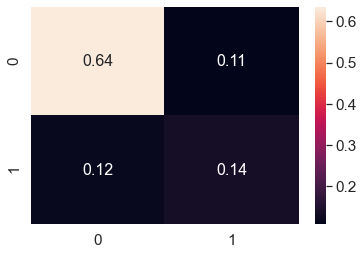

In [80]:
#Confussion matrix for the highest which is DecisionTreeClassifier
cm=confusion_matrix(y_test,y_pred)
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm/np.sum(cm), annot=True, annot_kws={"size": 16}) # font size